# Some Pytorch experiments

In [1]:
import lettertask
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import lazytools_sflippl as lazytools
import plotnine as gg
from tqdm import tqdm

In [185]:
cbm = lettertask.data.CompositionalBinaryModel(
    width=[2],
    change_probability=[0.05],
    samples=10000,
    seed=1001
)

## Supervised model

In [151]:
class CompositionalBinaryData:
    def __init__(self, cbm):
        self.cbm = cbm

    def __len__(self):
        len(self.cbm.atoms[0].values)

    def __getitem__(self, idx):
        arr = np.zeros(shape=(1, 2))
        arr[0, self.cbm.atoms[0].locations[idx]] = self.cbm.atoms[0].values[idx]
        latent_value = self.cbm.atoms[0].values[idx]
        return {'input': torch.from_numpy(arr.astype(np.float32)),
                'latent_value': torch.from_numpy(latent_value.astype(np.float32))}

In [152]:
cbd = CompositionalBinaryData(cbm)

In [153]:
cbd[0]

{'input': tensor([[1., 0.]]), 'latent_value': tensor([1.])}

In [154]:
class Classification(nn.Module):
    def __init__(self):
        super().__init__()
        self.classification = nn.Linear(2, 1, bias=False)

    def forward(self, x):
        return self.classification(x)

In [155]:
criterion = nn.MSELoss()

In [156]:
clss = Classification()

In [157]:
optimizer = optim.SGD(clss.parameters(), lr=0.01)

In [158]:
for i, data in enumerate(cbd):
    optimizer.zero_grad()
    prediction = clss(data['input'])
    loss = criterion(prediction, data['latent_value'].unsqueeze(1))
    loss.backward()
    optimizer.step()

In [159]:
list(clss.parameters())

[Parameter containing:
 tensor([[1.0000, 1.0000]], requires_grad=True)]

## Prediction

In [186]:
class Predictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.predictor = nn.Linear(1, 5, bias=False)

    def forward(self, x):
        return self.predictor(x)

In [187]:
class TimeSeriesCBD(torch.utils.data.Dataset):
    def __init__(self, cbm, timesteps=2):
        super().__init__()
        self.cbm = cbm
        self.timesteps = timesteps

    def __len__(self):
        return len(self.cbm.atoms[0].values)-self.timesteps

    def __getitem__(self, idx):
        return {
            'current_value': torch.from_numpy(self.cbm.atoms[0].values[idx].astype(np.float32)),
            'future_values': torch.from_numpy(self.cbm.atoms[0].values[(idx+1):(idx+1+self.timesteps)].astype(np.float32))
        }

In [188]:
tscbd = TimeSeriesCBD(cbm, timesteps=5)

In [189]:
pred = Predictor()

In [190]:
optimizer = optim.SGD(pred.parameters(), lr=0.01)

In [191]:
len(tscbd)

99995

In [212]:
for epoch in range(10):
    for i, data in enumerate(tscbd):
        if i>=len(tscbd): break
        optimizer.zero_grad()
        prediction = pred(data['current_value'])
        loss = criterion(prediction, data['future_values'].reshape(5))
        loss.backward()
        optimizer.step()

In [213]:
list(pred.parameters())

[Parameter containing:
 tensor([[0.9053],
         [0.8174],
         [0.7488],
         [0.6973],
         [0.6531]], requires_grad=True)]

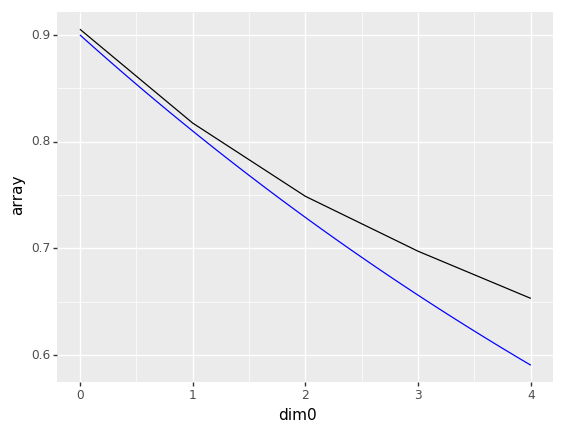

<ggplot: (8748566024009)>

In [214]:
(gg.ggplot(lazytools.array_to_dataframe(list(pred.parameters())[0].detach().numpy())) + 
 gg.geom_line(gg.aes(x = 'dim0', y = 'array')) + 
 gg.stat_function(fun = lambda x: 0.9**(x+1), color='blue')
)

## Predicting future latents

In [208]:
class LatentTimeSeries(torch.utils.data.Dataset):
    def __init__(self, cbm, timesteps=5):
        super().__init__()
        self.timesteps = timesteps
        self.cbm = cbm

    def __len__(self):
        return len(self.cbm.atoms[0].values)-self.timesteps

    def __getitem__(self, idx):
        arr = np.zeros(shape=(1, 2))
        arr[0, self.cbm.atoms[0].locations[idx]] = self.cbm.atoms[0].values[idx]
        return {
            'current_value': torch.from_numpy(arr.astype(np.float32)),
            'future_latent_values': torch.from_numpy(self.cbm.atoms[0].values[(idx+1):(idx+1+self.timesteps)].astype(np.float32))
        }

In [209]:
lts = LatentTimeSeries(cbm)

In [224]:
class LatentPrediction(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(2, 1, bias=False)
        self.predictor = nn.Linear(1, 5, bias=False)

    def forward(self, x):
        latent = self.encoder(x)
        prediction = self.predictor(latent)
        return prediction

In [225]:
lp = LatentPrediction()

In [226]:
optimizer = optim.SGD(lp.parameters(), lr=0.01)

In [229]:
for epoch in range(10):
    for i, data in enumerate(lts):
        if i>=len(tscbd): break
        optimizer.zero_grad()
        prediction = lp(data['current_value'])
        loss = criterion(prediction, data['future_latent_values'].transpose(0, 1))
        loss.backward()
        optimizer.step()

In [230]:
list(lp.parameters())

[Parameter containing:
 tensor([[-1.2120, -1.1849]], requires_grad=True), Parameter containing:
 tensor([[-0.8023],
         [-0.7269],
         [-0.6721],
         [-0.6310],
         [-0.5958]], requires_grad=True)]

Except for the one degree of freedom, this looks pretty good.

What happens with a smarter optimizer?

In [233]:
lp = LatentPrediction()

In [234]:
optimizer = optim.Adam(lp.parameters())

In [237]:
for epoch in tqdm(range(10)):
    for i, data in enumerate(lts):
        if i>=len(tscbd): break
        optimizer.zero_grad()
        prediction = lp(data['current_value'])
        loss = criterion(prediction, data['future_latent_values'].transpose(0, 1))
        loss.backward()
        optimizer.step()

100%|██████████| 10/10 [06:26<00:00, 38.13s/it]


In [239]:
list(lp.parameters())

[Parameter containing:
 tensor([[-0.9485, -0.9470]], requires_grad=True), Parameter containing:
 tensor([[-0.9578],
         [-0.8552],
         [-0.7686],
         [-0.6976],
         [-0.6323]], requires_grad=True)]

This looks remarkably good!

## Predicting future input

In [283]:
class BasicPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(2, 1, bias=False)
        self.predictor = nn.Linear(1, 5, bias=False)
        self.decoder = nn.Conv1d(1, 2, 1, bias=False)

    def forward(self, x):
        code = self.encoder(x['current_value'])
        prediction = self.predictor(code)
        decoded = self.decoder(prediction).transpose(1, 2)
        return decoded

In [284]:
class TimeSeries(torch.utils.data.Dataset):
    def __init__(self, cbm, timesteps=5):
        super().__init__()
        self.cbm = cbm
        self.timesteps = timesteps

    def __len__(self):
        return len(self.cbm.atoms[0].values)-self.timesteps

    def __getitem__(self, idx):
        arr = np.zeros(shape=(1, 1, 2))
        arr[0, 0, self.cbm.atoms[0].locations[idx]] = self.cbm.atoms[0].values[idx]
        fut_arr = np.zeros(shape=(1, self.timesteps, 2))
        for t in range(self.timesteps):
            fut_arr[0, t, self.cbm.atoms[0].locations[idx+t]] = self.cbm.atoms[0].values[idx+t]
        return {
            'current_value': torch.from_numpy(arr.astype(np.float32)),
            'future_values': torch.from_numpy(fut_arr.astype(np.float32))
        }

In [285]:
ts = TimeSeries(cbm)

In [286]:
ts[0]

{'current_value': tensor([[[1., 0.]]]), 'future_values': tensor([[[1., 0.],
          [1., 0.],
          [0., 1.],
          [1., 0.],
          [0., 1.]]])}

In [287]:
bp = BasicPredictor()

In [288]:
code = bp.encoder(ts[0]['current_value'])

In [289]:
prediction = bp.predictor(code)

In [291]:
bp.decoder(prediction.reshape(1,1,5)).transpose(1, 2)

tensor([[[-0.0020, -0.0116],
         [-0.0163, -0.0961],
         [-0.0137, -0.0805],
         [-0.0135, -0.0793],
         [ 0.0234,  0.1374]]], grad_fn=<TransposeBackward0>)

In [292]:
optimizer = optim.Adam(bp.parameters())

In [294]:
for epoch in tqdm(range(10)):
    for i, data in enumerate(ts):
        if i>=len(ts): break
        optimizer.zero_grad()
        prediction = bp(data)
        loss = criterion(prediction, data['future_values'])
        loss.backward()
        optimizer.step()

 70%|███████   | 7/10 [22:44<09:49, 196.45s/it]

KeyboardInterrupt: 

In [295]:
list(bp.parameters())

[Parameter containing:
 tensor([[-0.8023, -0.7992]], requires_grad=True), Parameter containing:
 tensor([[-0.7629],
         [-0.6909],
         [-0.6102],
         [-0.5326],
         [-0.4685]], requires_grad=True), Parameter containing:
 tensor([[[0.8007]],
 
         [[0.8227]]], requires_grad=True)]

## Can we apply the same encoder faithfully to several instances?

In [334]:
class SeveralTimes(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(1, 1, bias=False)

    def forward(self, x):
        return self.encoder(x)

In [335]:
st = SeveralTimes()

In [336]:
optimizer = optim.SGD(st.parameters(), lr=0.01)

In [337]:
pred1 = st(torch.from_numpy(np.array([[1]]).astype(np.float32)))

In [338]:
pred1

tensor([[0.8733]], grad_fn=<MmBackward>)

In [343]:
for __ in range(100):
    optimizer.zero_grad()
    pred1 = st(torch.from_numpy(np.array([[1]]).astype(np.float32)))
    pred2 = st(torch.from_numpy(np.array([[-1]]).astype(np.float32)))
    loss = (pred1-1)**2+pred2**2
    loss.backward()
    optimizer.step()

In [344]:
list(st.parameters())

[Parameter containing:
 tensor([[0.5082]], requires_grad=True)]

## Move to the latents

In [357]:
class ContrastiveTimeSeries(torch.utils.data.Dataset):
    def __init__(self, cbm, timesteps=5, n_contrasts=10):
        super().__init__()
        self.cbm = cbm
        self.timesteps = timesteps
        self.n_contrasts = n_contrasts

    def __len__(self):
        return len(self.cbm.atoms[0].values)-self.timesteps

    def __getitem__(self, idx):
        arr = np.zeros(shape=(1, 1, 2))
        arr[0, 0, self.cbm.atoms[0].locations[idx]] = self.cbm.atoms[0].values[idx]
        fut_arr = np.zeros(shape=(1, self.timesteps, 2))
        con_arr = np.zeros(shape=(self.n_contrasts, self.timesteps, 2))
        con_idx = np.random.randint(len(self.cbm.atoms[0].values), size=self.n_contrasts)
        for t in range(self.timesteps):
            fut_arr[0, t, self.cbm.atoms[0].locations[idx+t]] = self.cbm.atoms[0].values[idx+t]
        for t in range(self.timesteps):
            for i, c_idx in enumerate(con_idx):
                con_arr[i, t, self.cbm.atoms[0].locations[c_idx]] = self.cbm.atoms[0].values[c_idx]
        return {
            'current_value': torch.from_numpy(arr.astype(np.float32)),
            'future_values': torch.from_numpy(fut_arr.astype(np.float32)),
            'contrastive_values': torch.from_numpy(con_arr.astype(np.float32))
        }

In [358]:
cts = ContrastiveTimeSeries(cbm)

In [368]:
class ContrastiveEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(2, 1, bias=False)
        self.predictor = nn.Linear(1, 5, bias=False)

    def forward(self, x):
        current_code = self.encoder(x['current_value'])
        future_code = self.encoder(x['future_values'])
        contrastive_code = self.encoder(x['contrastive_values'])
        predicted_code = self.predictor(current_code).reshape(1, 5, 1)
        dct = {
            'future_code': future_code,
            'contrastive_code': contrastive_code,
            'predicted_code': predicted_code
        }
        return dct

In [369]:
ce = ContrastiveEncoder()

In [414]:
def criterion(values):
    correct_category = torch.sum(
        values['future_code'] * values['predicted_code'],
        axis=2
    )
    contrast_category = torch.sum(
        values['predicted_code'] * values['contrastive_code'],
        axis=2
    )
    loss_per_timestep = -correct_category + \
        torch.log(torch.exp(correct_category).sum(axis=0) + \
                  torch.exp(contrast_category).sum(axis=0))
    loss = loss_per_timestep.sum()
    return loss

In [413]:
optimizer = optim.Adam(ce.parameters())

In [416]:
for epoch in tqdm(range(5)):
    for i, data in enumerate(cts):
        if i>=len(cts): break
        optimizer.zero_grad()
        code = ce(data)
        loss = criterion(code)
        loss.backward()
        optimizer.step()


100%|██████████| 5/5 [09:26<00:00, 115.64s/it]


In [417]:
list(ce.parameters())

[Parameter containing:
 tensor([[0.9045, 0.9687]], requires_grad=True), Parameter containing:
 tensor([[4.5401],
         [1.6955],
         [1.2917],
         [1.0597],
         [0.9050]], requires_grad=True)]

In [419]:
for epoch in tqdm(range(5)):
    for i, data in enumerate(cts):
        if i>=len(cts): break
        optimizer.zero_grad()
        code = ce(data)
        loss = criterion(code)
        loss.backward()
        optimizer.step()


100%|██████████| 5/5 [08:45<00:00, 105.86s/it]


In [420]:
list(ce.parameters())

[Parameter containing:
 tensor([[0.8741, 0.9153]], requires_grad=True), Parameter containing:
 tensor([[4.9024],
         [1.8503],
         [1.4086],
         [1.1540],
         [0.9822]], requires_grad=True)]

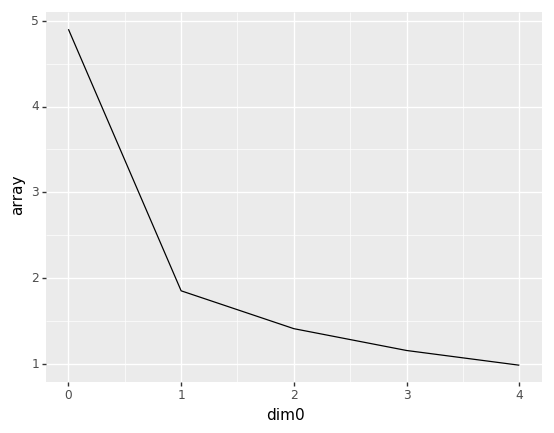

<ggplot: (8748554906725)>

In [425]:
(gg.ggplot(lazytools.array_to_dataframe(list(ce.parameters())[1].detach().numpy())) + 
 gg.geom_line(gg.aes(x = 'dim0', y = 'array'))
)

## Scaling up

### 1 ${\rm CBM}(20,0.05)$

In [434]:
class ContrastiveTimeSeries(torch.utils.data.Dataset):
    def __init__(self, cbm, timesteps=5, n_contrasts=10):
        super().__init__()
        self.cbm = cbm
        self.timesteps = timesteps
        self.n_contrasts = n_contrasts

    def __len__(self):
        return len(self.cbm.atoms[0].values)-self.timesteps

    def __getitem__(self, idx):
        arr = np.zeros(shape=(1, 1, 20))
        arr[0, 0, self.cbm.atoms[0].locations[idx]] = self.cbm.atoms[0].values[idx]
        fut_arr = np.zeros(shape=(1, self.timesteps, 20))
        con_arr = np.zeros(shape=(self.n_contrasts, self.timesteps, 20))
        con_idx = np.random.randint(len(self.cbm.atoms[0].values), size=self.n_contrasts)
        for t in range(self.timesteps):
            fut_arr[0, t, self.cbm.atoms[0].locations[idx+t]] = self.cbm.atoms[0].values[idx+t]
        for t in range(self.timesteps):
            for i, c_idx in enumerate(con_idx):
                con_arr[i, t, self.cbm.atoms[0].locations[c_idx]] = self.cbm.atoms[0].values[c_idx]
        return {
            'current_value': torch.from_numpy(arr.astype(np.float32)),
            'future_values': torch.from_numpy(fut_arr.astype(np.float32)),
            'contrastive_values': torch.from_numpy(con_arr.astype(np.float32))
        }

class ContrastiveEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(20, 1, bias=False)
        self.predictor = nn.Linear(1, 5, bias=False)

    def forward(self, x):
        current_code = self.encoder(x['current_value'])
        future_code = self.encoder(x['future_values'])
        contrastive_code = self.encoder(x['contrastive_values'])
        predicted_code = self.predictor(current_code).reshape(1, 5, 1)
        dct = {
            'future_code': future_code,
            'contrastive_code': contrastive_code,
            'predicted_code': predicted_code
        }
        return dct

In [444]:
cbm = lettertask.data.CompositionalBinaryModel(
    width=[20],
    change_probability=[0.05],
    samples=50000,
    seed=1001
)
cts_1 = ContrastiveTimeSeries(cbm)
ce_1 = ContrastiveEncoder()
optimizer = optim.Adam(ce_1.parameters())
for epoch in tqdm(range(5)):
    for i, data in enumerate(cts_1):
        if not i>=len(cts_1):
            optimizer.zero_grad()
            code = ce_1(data)
            loss = criterion(code)
            loss.backward()
            optimizer.step()



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:46<03:07, 46.84s/it]

 40%|████      | 2/5 [01:39<02:25, 48.62s/it]

 60%|██████    | 3/5 [02:29<01:38, 49.12s/it]

 80%|████████  | 4/5 [03:18<00:48, 48.95s/it]

100%|██████████| 5/5 [04:05<00:00, 48.35s/it]



In [445]:
list(ce_1.parameters())

[Parameter containing:
 tensor([[-0.8250, -0.8240,  0.8168,  0.9026, -0.8347,  0.8438,  0.8575, -0.8682,
          -0.7818,  0.8528, -0.8190,  0.0110,  0.8510,  0.8301,  0.7982, -0.8431,
           0.8483,  0.8636,  0.0286,  0.8959]], requires_grad=True),
 Parameter containing:
 tensor([[5.9478],
         [0.1140],
         [0.1241],
         [0.0489],
         [0.0824]], requires_grad=True)]

### 2 $CBM(20, 0.2)$

In [446]:
cbm = lettertask.data.CompositionalBinaryModel(
    width=[20],
    change_probability=[0.2],
    samples=50000,
    seed=1001
)
cts_2 = ContrastiveTimeSeries(cbm)
ce_2 = ContrastiveEncoder()
optimizer = optim.Adam(ce_2.parameters())
for epoch in tqdm(range(5)):
    for i, data in enumerate(cts_2):
        if not i>=len(cts_2):
            optimizer.zero_grad()
            code = ce_2(data)
            loss = criterion(code)
            loss.backward()
            optimizer.step()



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:48<03:15, 48.93s/it]

 40%|████      | 2/5 [01:35<02:24, 48.29s/it]

 60%|██████    | 3/5 [02:21<01:34, 47.41s/it]

 80%|████████  | 4/5 [03:08<00:47, 47.45s/it]

100%|██████████| 5/5 [04:02<00:00, 49.48s/it]



In [447]:
list(ce_2.parameters())

[Parameter containing:
 tensor([[ 0.8510,  0.8656,  0.8682, -0.8941,  0.0086, -0.8894, -0.8768,  0.8949,
          -0.8219, -0.8776,  0.8535,  0.8585, -0.8531,  0.0019, -0.8253, -0.8776,
          -0.0060,  0.8688,  0.0152,  0.8900]], requires_grad=True),
 Parameter containing:
 tensor([[ 6.8710],
         [ 0.0183],
         [-0.0285],
         [ 0.0083],
         [-0.0089]], requires_grad=True)]

### 3 CBM((1,1),(0.05, 0.5))

In [448]:
class ContrastiveTimeSeries(torch.utils.data.Dataset):
    def __init__(self, cbm, timesteps=5, n_contrasts=10):
        super().__init__()
        self.cbm = cbm
        self.timesteps = timesteps
        self.n_contrasts = n_contrasts

    def __len__(self):
        return len(self.cbm.atoms[0].values)-self.timesteps

    def __getitem__(self, idx):
        arr = np.zeros(shape=(1, 1, 2))
        arr[0, 0, self.cbm.atoms[0].locations[idx]] = self.cbm.atoms[0].values[idx]
        fut_arr = np.zeros(shape=(1, self.timesteps, 2))
        con_arr = np.zeros(shape=(self.n_contrasts, self.timesteps, 2))
        con_idx = np.random.randint(len(self.cbm.atoms[0].values), size=self.n_contrasts)
        for t in range(self.timesteps):
            fut_arr[0, t, self.cbm.atoms[0].locations[idx+t]] = self.cbm.atoms[0].values[idx+t]
        for t in range(self.timesteps):
            for i, c_idx in enumerate(con_idx):
                con_arr[i, t, self.cbm.atoms[0].locations[c_idx]] = self.cbm.atoms[0].values[c_idx]
        return {
            'current_value': torch.from_numpy(arr.astype(np.float32)),
            'future_values': torch.from_numpy(fut_arr.astype(np.float32)),
            'contrastive_values': torch.from_numpy(con_arr.astype(np.float32))
        }

class ContrastiveEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(2, 1, bias=False)
        self.predictor = nn.Linear(1, 5, bias=False)

    def forward(self, x):
        current_code = self.encoder(x['current_value'])
        future_code = self.encoder(x['future_values'])
        contrastive_code = self.encoder(x['contrastive_values'])
        predicted_code = self.predictor(current_code).reshape(1, 5, 1)
        dct = {
            'future_code': future_code,
            'contrastive_code': contrastive_code,
            'predicted_code': predicted_code
        }
        return dct

In [452]:
cbm = lettertask.data.CompositionalBinaryModel(
    width=[1, 1],
    change_probability=[0.05, 0.5],
    samples=10000,
    seed=1001
)
cts_3 = ContrastiveTimeSeries(cbm)
ce_3 = ContrastiveEncoder()
optimizer = optim.Adam(ce_3.parameters())
for epoch in tqdm(range(10)):
    for i, data in enumerate(cts_3):
        if not i>=len(cts_3):
            optimizer.zero_grad()
            code = ce_3(data)
            loss = criterion(code)
            loss.backward()
            optimizer.step()



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:08<01:20,  8.97s/it]

 20%|██        | 2/10 [00:18<01:12,  9.01s/it]

 30%|███       | 3/10 [00:26<01:02,  8.96s/it]

 40%|████      | 4/10 [00:35<00:53,  8.96s/it]

 50%|█████     | 5/10 [00:45<00:46,  9.27s/it]

 60%|██████    | 6/10 [00:55<00:37,  9.28s/it]

 70%|███████   | 7/10 [01:04<00:28,  9.35s/it]

 80%|████████  | 8/10 [01:14<00:18,  9.35s/it]

 90%|█████████ | 9/10 [01:23<00:09,  9.29s/it]

100%|██████████| 10/10 [01:32<00:00,  9.41s/it]



In [451]:
list(ce_3.parameters())

[Parameter containing:
 tensor([[ 0.9722, -0.3759]], requires_grad=True), Parameter containing:
 tensor([[10.8543],
         [ 1.6101],
         [ 1.2256],
         [ 1.0053],
         [ 0.8537]], requires_grad=True)]

## Next steps

We can use the compositional binary model to map out a couple of dimensions, both with respect to the data and with respect to the optimization undertaken. The dependent variables of interest are:

- computing time
- performance w.r.t. the loss
- performance as an angle to optimal latent feature recognition

The variables that influence these dependent variables are:

- sampling size
- optimizer
- CBM parameters
- number of epochs
- other aspects of the optimization paradigm

The algorithm that are (essentially) a bound from above are $L(t)\mapsto L(t+\tau)$ and $X(t)\mapsto L(t+\tau)$. The algorithm that should provide a baseline is $X(t)\mapsto X(t+\tau)$.

## Early API

For this purpose, I have written a simple API providing the functionality we draw upon in this notebook:

In [2]:
import patches

In [3]:
cbm = lettertask.data.CompositionalBinaryModel(
    width=[1, 1],
    change_probability=[0.05, 0.5],
    samples=10000,
    seed=1001
)

In [4]:
cts = patches.data.Contrastive1DTimeSeries(data=cbm.to_array())

In [5]:
ce = patches.networks.LinearScaffold(latent_features=1, data=cts)

In [8]:
criterion = patches.losses.ContrastiveLoss(loss=nn.MSELoss())

In [11]:
optimizer = optim.Adam(ce.parameters())

In [13]:
for epoch in tqdm(range(10)):
    for i, data in enumerate(cts):
        if i<len(cts):
            optimizer.zero_grad()
            code = ce(data)
            loss = criterion(code)
            loss.backward()
            optimizer.step()

100%|██████████| 10/10 [03:18<00:00, 19.89s/it]


In [14]:
list(ce.parameters())

[Parameter containing:
 tensor([[-0.6315, -0.0026]], requires_grad=True), Parameter containing:
 tensor([0.0639], requires_grad=True), Parameter containing:
 tensor([[1.9455],
         [1.4711],
         [1.1982],
         [1.0080],
         [0.8622]], requires_grad=True), Parameter containing:
 tensor([-0.0358, -0.0031,  0.0155,  0.0286,  0.0388], requires_grad=True)]

Looking good!!

## Coming next
Preparations for the screening: Deriving the latent and encoding model, the latent predictive model, and the predictive model.